In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.api import stats
from statsmodels.stats.anova import anova_lm
from scipy.stats import f_oneway
from matplotlib.lines import Line2D


Import raw data from local drive. 

In [136]:
file_name = "Experimental_Structure_Data_05032025.xlsx"

fish = pd.read_excel(file_name, sheet_name='Fish')
relief = pd.read_excel(file_name, sheet_name='Relief')
species_codes = pd.read_excel(file_name, sheet_name='Species_Codes')

## Prepare Data

Calculate mean relief of each transect. Calculate standardized metrics for relief and substrate for each transect, and categorize transects as "High" or "Low" relief based on whether the mean relief values fall above or below 1.5, respectively. 

In [137]:
mean_relief= relief.groupby('Transect_Number')['Relief'].mean().reset_index(name='Mean_Relief')

mean_relief['Relief_Category'] = mean_relief['Mean_Relief'].apply(
    lambda x: 'High' if x >= 1.5 else 'Low'
)

Clean and prepare fish data. Calculate weighted size using size class data and pivot fish variables into workable format. 

In [138]:
fish_master = fish.merge(species_codes, on='Species', how='left')
fish_master = fish_master.merge(mean_relief, on = 'Transect_Number', how = 'left')

metadata = ['Date', 'Location', 'Recorder', 
                    'Buddy', 'Heading', 'Depth_ft']

fish_master = fish_master.drop(columns=metadata)
fish_master

,Transect_Number,Treatment,Treatment_Time,Species,Size_cm,Count,Common_Name,Mobility,Mean_Relief,Relief_Category
0,2,Pre-Kelp,0_hours,SMYS,15,6,Blue rockfish,Midwater,2.2,High
1,2,Pre-Kelp,0_hours,SMYS,20,6,Blue rockfish,Midwater,2.2,High
2,2,Post-Kelp,1_hour,SMYS,5,1,Blue rockfish,Midwater,2.2,High
3,2,Post-Kelp,1_hour,SMYS,15,4,Blue rockfish,Midwater,2.2,High
4,2,Post-Kelp,1_hour,SMYS,20,8,Blue rockfish,Midwater,2.2,High
...,...,...,...,...,...,...,...,...,...,...
166,11,Post-Kelp,1_hour,SMYS,5,10,Blue rockfish,Midwater,1.5,High
167,11,Post-Kelp,1_hour,SMYS,10,20,Blue rockfish,Midwater,1.5,High
168,11,Post-Kelp,1_hour,OPIC,5,1,Painted greenling,Benthic,1.5,High
169,11,Post-Kelp,1_hour,SCAR,25,1,Gopher rockfish,Benthic,1.5,High


## Relief

In [139]:
relief = fish_master.groupby(['Transect_Number', 'Relief_Category']).apply(
    lambda g: pd.Series({
        'total_abundance': g['Count'].sum(),
        'density_per_m2': g['Count'].sum() / 20,
        'richness': g['Species'].nunique(),
        'avg_size_weighted': np.average(g['Size_cm'], weights=g['Count']),
        'biodiversity': -np.sum((p := g.groupby('Species')['Count'].sum() / g['Count'].sum()) * np.log(p))
    })
).reset_index()

/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/177913067.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  relief = fish_master.groupby(['Transect_Number', 'Relief_Category']).apply(


In [140]:
relief

,Transect_Number,Relief_Category,total_abundance,density_per_m2,richness,avg_size_weighted,biodiversity
0,2,High,55.0,2.75,4.0,13.272727,0.336253
1,3,High,118.0,5.90,5.0,13.262712,0.264179
2,4,High,75.0,3.75,5.0,9.933333,0.519688
3,5,Low,34.0,1.70,9.0,11.617647,1.445936
4,6,Low,76.0,3.80,6.0,9.868421,0.926600
5,7,High,114.0,5.70,7.0,10.307018,0.704053
6,8,Low,51.0,2.55,6.0,6.764706,1.176026
7,9,High,96.0,4.80,9.0,9.427083,0.890616
8,10,Low,49.0,2.45,6.0,15.204082,0.954757
9,11,High,66.0,3.30,7.0,10.833333,1.103483


In [141]:
# List of metrics to test
metrics = ['density_per_m2', 'richness', 'avg_size_weighted', 'biodiversity']

# Loop through each metric and run ANOVA
for metric in metrics:
    # Group the data by Relief_Category
    groups = relief.groupby('Relief_Category')[metric].apply(list)

    # Perform one-way ANOVA
    f_stat, p_value = f_oneway(*groups)

    # Print results
    print(f"ANOVA for {metric}:")
    print(f"  F-statistic = {f_stat:.3f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("  → Significant difference by relief category (p < 0.05)")
    else:
        print("  → No significant difference (p ≥ 0.05)")
    print()

ANOVA for density_per_m2:
  F-statistic = 5.433, p-value = 0.0481
  → Significant difference by relief category (p < 0.05)

ANOVA for richness:
  F-statistic = 0.277, p-value = 0.6129
  → No significant difference (p ≥ 0.05)

ANOVA for avg_size_weighted:
  F-statistic = 0.036, p-value = 0.8550
  → No significant difference (p ≥ 0.05)

ANOVA for biodiversity:
  F-statistic = 6.537, p-value = 0.0338
  → Significant difference by relief category (p < 0.05)



In [142]:
# Metrics to plot
metrics = ['density_per_m2', 'richness', 'avg_size_weighted', 'biodiversity']
y_labels = {
    'density_per_m2': 'Density (count/m²)',
    'richness': 'Species Richness',
    'avg_size_weighted': 'Average Size (cm)',
    'biodiversity': 'Shannon Diversity (H\')'
}

# Loop through each metric and plot
for metric in metrics:
    plt.figure(figsize=(8, 6))

    # Create summary stats: mean and standard error
    plot_data = relief.groupby('Relief_Category')[metric].agg(['mean', 'sem']).reset_index()
    
    # Plot barplot without error bars (so we can add custom ones)
    sns.barplot(data=plot_data, x='Relief_Category', y='mean', palette='Dark2', errorbar=None)

    # Add standard error bars manually
    plt.errorbar(
        x=range(len(plot_data)),
        y=plot_data['mean'],
        yerr=plot_data['sem'],
        fmt='none',
        color='black',
        capsize=5
    )

    # Customize the plot
    plt.title(f'{y_labels[metric]} by Relief Category')
    plt.xlabel('Benthic Relief')
    plt.ylabel(y_labels[metric])
    plt.tight_layout()
    
        # Save the plot as a .png file
    save_path = os.path.join(output_dir, f"{metric}_by_Relief.png")
    plt.savefig(save_path, format='png')

    # Close the plot to prevent it from displaying multiple plots at once
    plt.close()

    print(f"Plot saved as: {save_path}")


/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/390216196.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='Relief_Category', y='mean', palette='Dark2', errorbar=None)
/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/390216196.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='Relief_Category', y='mean', palette='Dark2', errorbar=None)


Plot saved as: plots/density_per_m2_by_Relief.png
Plot saved as: plots/richness_by_Relief.png
Plot saved as: plots/avg_size_weighted_by_Relief.png


/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/390216196.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='Relief_Category', y='mean', palette='Dark2', errorbar=None)
/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/390216196.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='Relief_Category', y='mean', palette='Dark2', errorbar=None)


Plot saved as: plots/biodiversity_by_Relief.png


## Mobility

In [143]:
# Summarize by Mobility and Transect
mobility = fish_master.groupby(['Transect_Number', 'Mobility']).apply(
    lambda g: pd.Series({
        'total_abundance': g['Count'].sum(),
        'density_per_m2': g['Count'].sum() / 20,
        'richness': g['Species'].nunique(),
        'avg_size_weighted': np.average(g['Size_cm'], weights=g['Count']),
        'biodiversity': -np.sum((p := g.groupby('Species')['Count'].sum() / g['Count'].sum()) * np.log(p))
    })
).reset_index()


/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/937294039.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mobility = fish_master.groupby(['Transect_Number', 'Mobility']).apply(


In [150]:
# List of metrics to test
metrics = ['density_per_m2', 'richness', 'avg_size_weighted', 'biodiversity']

# Loop through each metric and run ANOVA and post hoc if significant
for metric in metrics:
    # Group the data by Mobility and create a list of observations for each group
    groups = mobility.groupby('Mobility')[metric].apply(list)

    # Perform one-way ANOVA
    f_stat, p_value = f_oneway(*groups)

    print(f"ANOVA for {metric} by Mobility:")
    print(f"  F-statistic = {f_stat:.3f}, p-value = {p_value:.4f}")

    if p_value < 0.05:
        print("  → Significant difference by Mobility (p < 0.05)")

        # If ANOVA is significant, perform Tukey's HSD test for post hoc analysis
        # Flatten the groups and create a dataframe for the Tukey test
        data = mobility[[metric, 'Mobility']]

        # Tukey HSD test
        tukey = pairwise_tukeyhsd(endog=data[metric], groups=data['Mobility'], alpha=0.05)

        # Print Tukey HSD results
        print("\nPost Hoc Tukey HSD Test Results:")
        print(tukey.summary())
    else:
        print("  → No significant difference (p ≥ 0.05)")
    
    print()


ANOVA for density_per_m2 by Mobility:
  F-statistic = 17.362, p-value = 0.0000
  → Significant difference by Mobility (p < 0.05)

Post Hoc Tukey HSD Test Results:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------
       Benthic Bentho-pelagic  -0.1513 0.9468 -1.3465  1.044  False
       Benthic       Midwater   2.2638 0.0002  1.0685  3.459   True
Bentho-pelagic       Midwater    2.415    0.0  1.2881 3.5419   True
-------------------------------------------------------------------

ANOVA for richness by Mobility:
  F-statistic = 11.048, p-value = 0.0004
  → Significant difference by Mobility (p < 0.05)

Post Hoc Tukey HSD Test Results:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------

In [145]:
# Metrics to plot
metrics = ['density_per_m2', 'richness', 'avg_size_weighted', 'biodiversity']
y_labels = {
    'density_per_m2': 'Density (count/m²)',
    'richness': 'Species Richness',
    'avg_size_weighted': 'Average Size (cm)',
    'biodiversity': 'Shannon Diversity (H\')'
}

# Loop through each metric and plot
for metric in metrics:
    plt.figure(figsize=(8, 6))

    # Create summary stats: mean and standard error
    plot_data = mobility.groupby('Mobility')[metric].agg(['mean', 'sem']).reset_index()
    
    # Plot barplot without error bars (so we can add custom ones)
    sns.barplot(data=plot_data, x='Mobility', y='mean', palette='Blues', errorbar=None)

    # Add standard error bars manually
    plt.errorbar(
        x=range(len(plot_data)),
        y=plot_data['mean'],
        yerr=plot_data['sem'],
        fmt='none',
        color='black',
        capsize=5
    )

    # Customize the plot
    plt.title(f'{y_labels[metric]} by Mobility Group')
    plt.xlabel('Mobility Group')
    plt.ylabel(y_labels[metric])
    plt.tight_layout()
    
    # Save the plot as a .png file
    save_path = os.path.join(output_dir, f"{metric}_by_Mobility.png")
    plt.savefig(save_path, format='png')

    # Close the plot to prevent it from displaying multiple plots at once
    plt.close()

    print(f"Plot saved as: {save_path}")


/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/1666304218.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='Mobility', y='mean', palette='Blues', errorbar=None)


Plot saved as: plots/density_per_m2_by_Mobility.png


/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/1666304218.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='Mobility', y='mean', palette='Blues', errorbar=None)


Plot saved as: plots/richness_by_Mobility.png
Plot saved as: plots/avg_size_weighted_by_Mobility.png


/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/1666304218.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='Mobility', y='mean', palette='Blues', errorbar=None)
/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/1666304218.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='Mobility', y='mean', palette='Blues', errorbar=None)


Plot saved as: plots/biodiversity_by_Mobility.png


## Treatment

In [146]:
# Summarize by Mobility and Transect
treatment = fish_master.groupby(['Transect_Number', 'Treatment_Time']).apply(
    lambda g: pd.Series({
        'total_abundance': g['Count'].sum(),
        'density_per_m2': g['Count'].sum() / 20,
        'richness': g['Species'].nunique(),
        'avg_size_weighted': np.average(g['Size_cm'], weights=g['Count']),
        'biodiversity': -np.sum((p := g.groupby('Species')['Count'].sum() / g['Count'].sum()) * np.log(p))
    })
).reset_index()


/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/2186161687.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treatment = fish_master.groupby(['Transect_Number', 'Treatment_Time']).apply(


In [147]:
metrics = ['density_per_m2', 'richness', 'avg_size_weighted', 'biodiversity']

for metric in metrics:
    groups = treatment.groupby('Treatment_Time')[metric].apply(list)

    f_stat, p_value = f_oneway(*groups)

    print(f"ANOVA for {metric} by Treatment:")
    print(f"  F-statistic = {f_stat:.3f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("  → Significant difference by Treatment (p < 0.05)")
    else:
        print("  → No significant difference (p ≥ 0.05)")
    print()


ANOVA for density_per_m2 by Treatment:
  F-statistic = 0.095, p-value = 0.9098
  → No significant difference (p ≥ 0.05)

ANOVA for richness by Treatment:
  F-statistic = 0.410, p-value = 0.6685
  → No significant difference (p ≥ 0.05)

ANOVA for avg_size_weighted by Treatment:
  F-statistic = 1.076, p-value = 0.3568
  → No significant difference (p ≥ 0.05)

ANOVA for biodiversity by Treatment:
  F-statistic = 0.120, p-value = 0.8875
  → No significant difference (p ≥ 0.05)



In [148]:
metrics = ['density_per_m2', 'richness', 'avg_size_weighted', 'biodiversity']
y_labels = {
    'density_per_m2': 'Density (per 20 m²)',
    'richness': 'Species Richness',
    'avg_size_weighted': 'Weighted Avg Size (cm)',
    'biodiversity': 'Shannon Biodiversity'
}

# Create a directory to save the plots
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

# Loop through metrics and plot
for metric in metrics:
    # Compute mean and standard error by Mobility
    summary = treatment.groupby('Treatment_Time')[metric].agg(['mean', 'std', 'count']).reset_index()
    summary['sem'] = summary['std'] / np.sqrt(summary['count'])

    # Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(data=summary, x='Treatment_Time', y='mean', palette='YlGn', errorbar=None)

    # Add error bars manually
    plt.errorbar(x=range(len(summary)),
                 y=summary['mean'],
                 yerr=summary['sem'],
                 fmt='none', c='black', capsize=5)

    # Set plot labels and title
    plt.title(f"{y_labels[metric]} by Treatment_Time", fontsize=14)
    plt.ylabel(y_labels[metric], fontsize=12)
    plt.xlabel('Treatment', fontsize=12)
    plt.tight_layout()

    # Save the plot as a .png file
    save_path = os.path.join(output_dir, f"{metric}_by_Treatment.png")
    plt.savefig(save_path, format='png')

    # Close the plot to prevent it from displaying multiple plots at once
    plt.close()

    print(f"Plot saved as: {save_path}")


/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/2975591651.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='Treatment_Time', y='mean', palette='YlGn', errorbar=None)


Plot saved as: plots/density_per_m2_by_Treatment.png


/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/2975591651.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='Treatment_Time', y='mean', palette='YlGn', errorbar=None)


Plot saved as: plots/richness_by_Treatment.png


/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/2975591651.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='Treatment_Time', y='mean', palette='YlGn', errorbar=None)


Plot saved as: plots/avg_size_weighted_by_Treatment.png
Plot saved as: plots/biodiversity_by_Treatment.png


/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/2975591651.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='Treatment_Time', y='mean', palette='YlGn', errorbar=None)


## Species

In [151]:
species = fish_master.groupby(['Transect_Number', 'Species']).apply(
    lambda g: pd.Series({
        'total_abundance': g['Count'].sum(),
        'density_per_m2': g['Count'].sum() / 20,
        'avg_size_weighted': np.average(g['Size_cm'], weights=g['Count']),
    })
).reset_index()

/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/987464817.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  species = fish_master.groupby(['Transect_Number', 'Species']).apply(


In [165]:
# List of metrics to test
metrics = ['density_per_m2', 'avg_size_weighted']

# Loop through each metric and run ANOVA and post hoc if significant
for metric in metrics:
    # Group the data by Mobility and create a list of observations for each group
    groups = species.groupby('Species')[metric].apply(list)

    # Perform one-way ANOVA
    f_stat, p_value = f_oneway(*groups)

    print(f"ANOVA for {metric} by Species:")
    print(f"  F-statistic = {f_stat:.3f}, p-value = {p_value:.4f}")

    if p_value < 0.05:
        print("  → Significant difference by Species (p < 0.05)")

        # If ANOVA is significant, perform Tukey's HSD test for post hoc analysis
        # Flatten the groups and create a dataframe for the Tukey test
        data = species[[metric, 'Species']]

        # Tukey HSD test
        tukey = pairwise_tukeyhsd(endog=data[metric], groups=data['Species'], alpha=0.05)

        # Print Tukey HSD results
        print("\nPost Hoc Tukey HSD Test Results:")
        print(tukey.summary())
    else:
        print("  → No significant difference (p ≥ 0.05)")
    
    print()

ANOVA for density_per_m2 by Species:
  F-statistic = 7.506, p-value = 0.0000
  → Significant difference by Species (p < 0.05)

Post Hoc Tukey HSD Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  EJAC   ELAT      0.2    1.0 -1.6684  2.0684  False
  EJAC   HDEC  -0.0125    1.0 -2.0306  2.0056  False
  EJAC   OELO   0.1125    1.0 -2.1758  2.4008  False
  EJAC   OPIC   0.0804    1.0 -1.5758  1.7365  False
  EJAC   RNIC   0.2312    1.0 -1.3868  1.8493  False
  EJAC   RTOX  -0.0125    1.0 -2.9667  2.9417  False
  EJAC   RVAC   0.0208    1.0 -1.9973  2.0389  False
  EJAC   SATR   0.0661    1.0 -1.5901  1.7222  False
  EJAC   SCAR    0.025    1.0 -1.8434  1.8934  False
  EJAC   SCAU  -0.0125    1.0 -2.3008  2.2758  False
  EJAC   SMEL   0.0375    1.0 -2.2508  2.3258  False
  EJAC   SMIN  -0.0125    1.0 -2.0306  2.0056  False
  EJAC   SMYS   2.7475    0.0  1.1843  4.3107

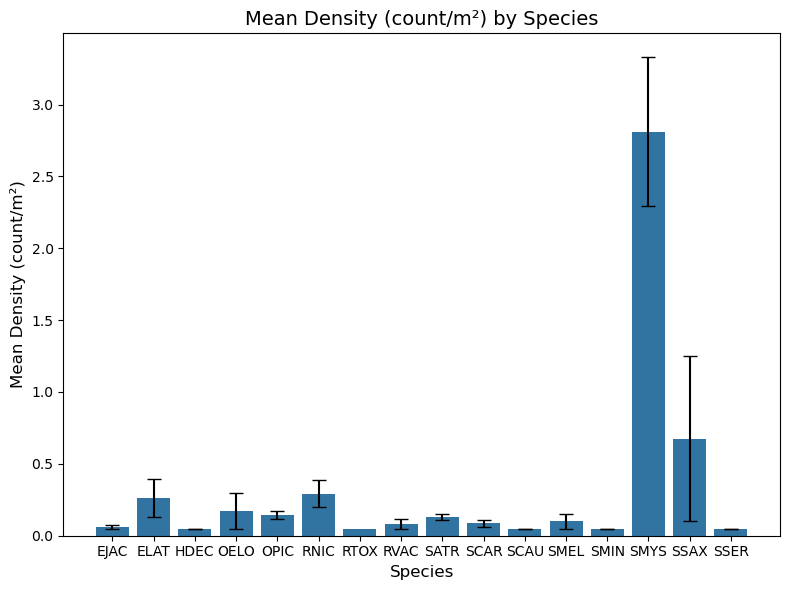

Plot saved as: plots/density_per_m2_by_Species.png


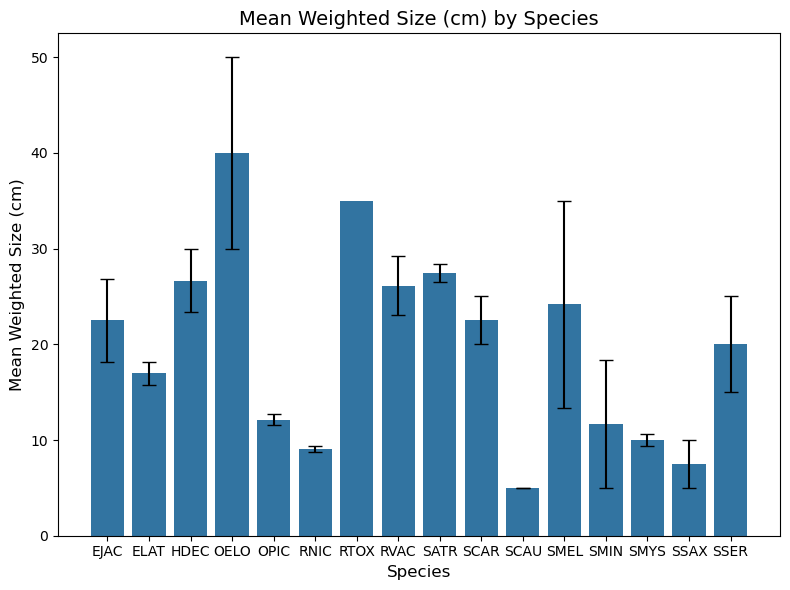

Plot saved as: plots/avg_size_weighted_by_Species.png


In [160]:
metrics = ['density_per_m2', 'avg_size_weighted']
y_labels = {
    'density_per_m2': 'Mean Density (count/m²)',
    'avg_size_weighted': 'Mean Weighted Size (cm)',
}

# Create a directory to save the plots
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

# Loop through metrics and plot
for metric in metrics:
    # Compute mean and standard error by Mobility
    summary = species.groupby('Species')[metric].agg(['mean', 'std', 'count']).reset_index()
    summary['sem'] = summary['std'] / np.sqrt(summary['count'])

    # Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(data=summary, x='Species', y='mean', errorbar=None)

    # Add error bars manually
    plt.errorbar(x=range(len(summary)),
                 y=summary['mean'],
                 yerr=summary['sem'],
                 fmt='none', c='black', capsize=5)

    # Set plot labels and title
    plt.title(f"{y_labels[metric]} by Species", fontsize=14)
    plt.ylabel(y_labels[metric], fontsize=12)
    plt.xlabel('Species', fontsize=12)
    plt.tight_layout()

    # Save the plot as a .png file
    save_path = os.path.join(output_dir, f"{metric}_by_Species.png")
    plt.savefig(save_path, format='png')

    # Close the plot to prevent it from displaying multiple plots at once
    plt.show()

    print(f"Plot saved as: {save_path}")

## Subset the data by blue rockfish 

In [170]:
smys_data = fish_master[fish_master['Species'] == 'SMYS']
smys_data

,Transect_Number,Treatment,Treatment_Time,Species,Size_cm,Count,Common_Name,Mobility,Mean_Relief,Relief_Category
0,2,Pre-Kelp,0_hours,SMYS,15,6,Blue rockfish,Midwater,2.2,High
1,2,Pre-Kelp,0_hours,SMYS,20,6,Blue rockfish,Midwater,2.2,High
2,2,Post-Kelp,1_hour,SMYS,5,1,Blue rockfish,Midwater,2.2,High
3,2,Post-Kelp,1_hour,SMYS,15,4,Blue rockfish,Midwater,2.2,High
4,2,Post-Kelp,1_hour,SMYS,20,8,Blue rockfish,Midwater,2.2,High
...,...,...,...,...,...,...,...,...,...,...
154,10,Post-Kelp,1_hour,SMYS,20,1,Blue rockfish,Midwater,1.3,Low
159,11,Pre-Kelp,0_hours,SMYS,10,10,Blue rockfish,Midwater,1.5,High
160,11,Pre-Kelp,0_hours,SMYS,15,3,Blue rockfish,Midwater,1.5,High
166,11,Post-Kelp,1_hour,SMYS,5,10,Blue rockfish,Midwater,1.5,High


In [174]:
blues = smys_data.groupby(['Transect_Number', 'Treatment_Time']).apply(
    lambda g: pd.Series({
        'total_abundance': g['Count'].sum(),
        'density_per_m2': g['Count'].sum() / 20,
        'richness': g['Species'].nunique(),
        'avg_size_weighted': np.average(g['Size_cm'], weights=g['Count']),
        'biodiversity': -np.sum((p := g.groupby('Species')['Count'].sum() / g['Count'].sum()) * np.log(p))
    })
).reset_index()
blues

/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_55503/3385318911.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  blues = smys_data.groupby(['Transect_Number', 'Treatment_Time']).apply(


,Transect_Number,Treatment_Time,total_abundance,density_per_m2,richness,avg_size_weighted,biodiversity
0,2,0_hours,22.0,1.10,1.0,11.818182,-0.0
1,2,1_hour,16.0,0.80,1.0,18.750000,-0.0
2,2,1_week,13.0,0.65,1.0,6.153846,-0.0
3,3,0_hours,53.0,2.65,1.0,10.849057,-0.0
4,3,1_hour,38.0,1.90,1.0,15.526316,-0.0
5,3,1_week,21.0,1.05,1.0,10.476190,-0.0
6,4,0_hours,33.0,1.65,1.0,6.363636,-0.0
7,4,1_hour,8.0,0.40,1.0,11.250000,-0.0
8,4,1_week,25.0,1.25,1.0,10.400000,-0.0
9,5,0_hours,9.0,0.45,1.0,10.000000,-0.0


In [173]:
for metric in metrics:
    groups = blues.groupby('Treatment_Time')[metric].apply(list)

    f_stat, p_value = f_oneway(*groups)

    print(f"ANOVA for {metric} by Treatment:")
    print(f"  F-statistic = {f_stat:.3f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("  → Significant difference by Treatment (p < 0.05)")
    else:
        print("  → No significant difference (p ≥ 0.05)")
    print()

ANOVA for density_per_m2 by Treatment:
  F-statistic = 0.085, p-value = 0.9185
  → No significant difference (p ≥ 0.05)

ANOVA for richness by Treatment:
  F-statistic = nan, p-value = nan
  → No significant difference (p ≥ 0.05)

ANOVA for avg_size_weighted by Treatment:
  F-statistic = 1.153, p-value = 0.3333
  → No significant difference (p ≥ 0.05)

ANOVA for biodiversity by Treatment:
  F-statistic = nan, p-value = nan
  → No significant difference (p ≥ 0.05)



/Users/carolinedaley/anaconda3/envs/data-25/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
/Users/carolinedaley/anaconda3/envs/data-25/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
